In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
df = pd.read_excel('/Uers/anthony/Desktop/INTONE/big_data.xls', dtype='object')
df.head()


,Unnamed: 0,SSN,bank account,Passport no.,card,transaction_ID,DL_EU,A_no,routing_no,insurance_no,ITIN
0,0,099-52-2802,5444452024994,49SN87292,4314-6417-5269-5130,CTID89983002,26047822,521-388-277,0226-2949-9,FF256881D,923 86-5944
1,1,925-64-0363,4637667944645,84DL48635,8066-8437-2479-2481,CTID19451148,10194874,325-523-274,1220-9406-8,SB219645C,941 70-1643
2,2,357-10-7658,6528340828416,30EZ99677,7615-9021-6282-1834,CTID38846768,52601167,466-454-528,1262-5881-7,AU694891A,952 76 6215
3,3,379 04 5699,5267132338946,53NT46760,1865 7979 5235 6125,CTID61506049,59963285,693-526-647,0380-7382-5,LQ884444A,910 71-7090
4,4,25151222,6714649391980,48QM30162,0613 7829 6768 6240,CTID99691250,63133530,521-396-239,7307-5857-6,QW750070B,966 73 5181


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65535 entries, 0 to 65534
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      65535 non-null  object
 1   SSN             62321 non-null  object
 2   bank account    63349 non-null  object
 3   Passport no.    62329 non-null  object
 4   card            62215 non-null  object
 5   transaction_ID  62048 non-null  object
 6   DL_EU           63445 non-null  object
 7   A_no            62504 non-null  object
 8   routing_no      62351 non-null  object
 9   insurance_no    62556 non-null  object
 10  ITIN            62541 non-null  object
dtypes: object(11)
memory usage: 5.5+ MB


In [20]:
df['category_id'] = df['type'].factorize()[0]
from io import StringIO
category_id_df = df[['type', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'type']].values)

KeyError: 'type'

In [21]:
id_to_category

NameError: name 'id_to_category' is not defined

In [7]:
df = df.drop([-1], axis=1)

KeyError: '[0] not found in axis'

In [ ]:
df.head()

<Figure size 800x600 with 0 Axes>

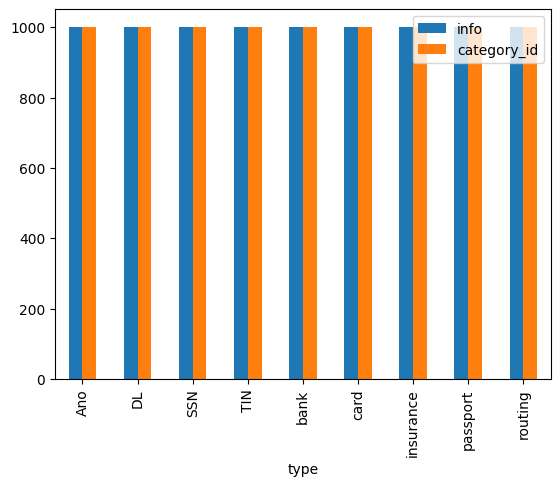

In [38]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('type').count().plot.bar(ylim=0)
plt.show()

In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidfVector = TfidfVectorizer(sublinear_tf=True, min_df=50, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

features = tfidfVector.fit_transform(df['info']).toarray()
labels = df.category_id
features.shape

(9007, 17)

In [47]:
from sklearn.feature_selection import chi2
import numpy as np
N = 2
for Product, category_id in sorted(category_to_id.items()):
    features_chi2 = chi2(features, labels == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidfVector.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}':".format(Product))
    print(" Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
    print(" Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'Ano':
 Most correlated unigrams:
. 81
. 71
 Most correlated bigrams:
. 
# 'DL':
 Most correlated unigrams:
. 81
. 71
 Most correlated bigrams:
. 
# 'SSN':
 Most correlated unigrams:
. 70
. 76
 Most correlated bigrams:
. 
# 'TIN':
 Most correlated unigrams:
. 80
. 71
 Most correlated bigrams:
. 
# 'bank':
 Most correlated unigrams:
. 81
. 71
 Most correlated bigrams:
. 
# 'card':
 Most correlated unigrams:
. 81
. 71
 Most correlated bigrams:
. 
# 'insurance':
 Most correlated unigrams:
. 81
. 71
 Most correlated bigrams:
. 
# 'passport':
 Most correlated unigrams:
. 81
. 71
 Most correlated bigrams:
. 
# 'routing':
 Most correlated unigrams:
. 81
. 71
 Most correlated bigrams:
. 


In [41]:
X_train = features
Y_train = labels

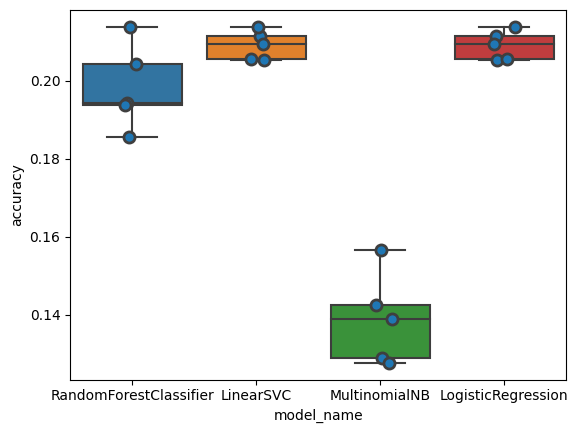

In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, X_train, Y_train, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()


In [43]:
cv_df.groupby('model_name').accuracy.mean()


model_name
LinearSVC                 0.20906
LogisticRegression        0.20906
MultinomialNB             0.13889
RandomForestClassifier    0.19829
Name: accuracy, dtype: float64

In [44]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)


In [45]:
model = LogisticRegression(random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

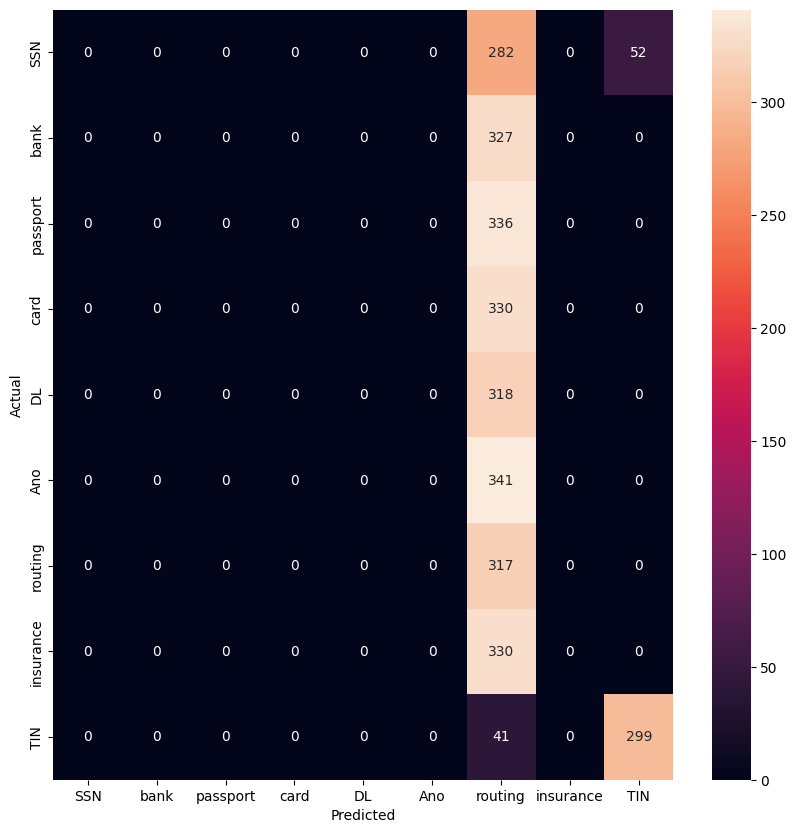

In [48]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.type.values, yticklabels=category_id_df.type.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()